The next two cells are preprocessing steps. They do not need to be run if you have the comic_faces and human_faces folder set up already.

In [ ]:
# Preprocessing step for the Google cartoons dataset - take the first 10k images (which are in folder "0") and insert them into the newly created "comic_images" folder

# Dataset downloaded from: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set/data and zip file was renamed to "cartoon.zip"

import os
import shutil

cartoon_folder = './cartoon/0/'
comic_faces_folder = './processed_dataset/comic_faces/'

if not os.path.exists(comic_faces_folder):
    os.makedirs(comic_faces_folder)

def move_to_comic_faces_folder(folder_name):
    for file in os.listdir(folder_name):
        src = os.path.join(folder_name, file)
        dst = os.path.join(comic_faces_folder, file)
        shutil.copy(src, dst)

move_to_comic_faces_folder(cartoon_folder)

In [ ]:
# Preprocessing step for the Celeb A human faces dataset
# Dataset downloaded from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset and zip file was renamed to "human_faces.zip"

# Retrieve the first 10000 human faces and place them on the "human_faces_processed" folder. This is done because the original dataset contains 200000+ faces, but a smaller-sized dataset can be uploaded to Google Collab for training and be trained on a single GPU.

face_limit = 10000
celeb_a_folder = './human_faces/img_align_celeba/img_align_celeba/'
human_faces_folder = './processed_dataset/human_faces/'

if not os.path.exists(human_faces_folder):
    os.makedirs(human_faces_folder)

# Copy the dataset
human_faces = os.listdir(celeb_a_folder)[:face_limit]
for file in human_faces:
    src = os.path.join(celeb_a_folder, file)
    dst = os.path.join(human_faces_folder, file)
    shutil.copy(src, dst)


Setting up the dataloader

In [2]:
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch

batch_size = 1
epochs = 28

# We resize the images to (140, 140) to have a standard size for the input, given that the images have different sizes in the celebA dataset

# We also leave the white background to create a cool, pastel-like effect on the human images

# For the dummy images used only for visualization, we don't normalize
transform_sample_images = transform = transforms.Compose([
    transforms.Resize((140, 140)),
    transforms.ToTensor(),
])

transform_production = transform = transforms.Compose([
    transforms.Resize((140, 140)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


class ImagesDataset(Dataset):
    def __init__(self, root_dirA, root_dirB, transform=transforms.ToTensor()):
        self.root_dirA = root_dirA
        self.root_dirB = root_dirB
        self.transform = transform

        self.imagesA = os.listdir(root_dirA)
        self.imagesB = os.listdir(root_dirB)

    def __len__(self):
        return max(len(self.imagesA), len(self.imagesB))

    def __getitem__(self, idx):
        img_nameA = os.path.join(self.root_dirA, self.imagesA[idx % len(self.imagesA)])
        img_nameB = os.path.join(self.root_dirB, self.imagesB[idx % len(self.imagesB)])

        imageA = Image.open(img_nameA)
        imageB = Image.open(img_nameB)

        if self.transform:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)

        return imageA, imageB


root = './processed_dataset/'
root_a = root + 'comic_faces/'
root_b = root + 'human_faces/'

image_folder_sample = datasets.ImageFolder(root=root, transform=transform_sample_images)

# Load the datasets
image_dataset = ImagesDataset(root_a, root_b, transform=transform_production)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

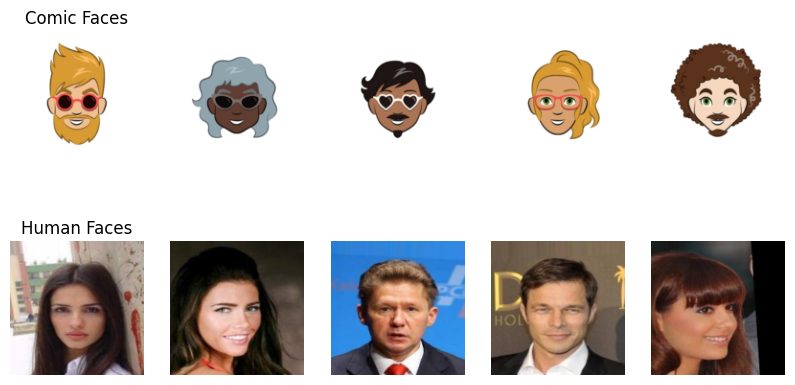

In [ ]:
# Plot sample input images
import matplotlib.pyplot as plt

class_a = 'comic_faces'
class_b = 'human_faces'
num_images = 5
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 5))

for i in range(num_images):
    image_a, _ = image_folder_sample[i]
    image_b, _ = image_folder_sample[i + len(image_folder_sample) // 2]
    image_a = image_a.permute(1, 2, 0)
    image_b = image_b.permute(1, 2, 0)
    axs[0, i].imshow(image_a)
    axs[1, i].imshow(image_b)
    axs[0, i].axis('off')
    axs[1, i].axis('off')

axs[0, 0].set_title("Comic Faces")
axs[1, 0].set_title("Human Faces")

plt.show()


Let's see what the initial outputs look like without any training.

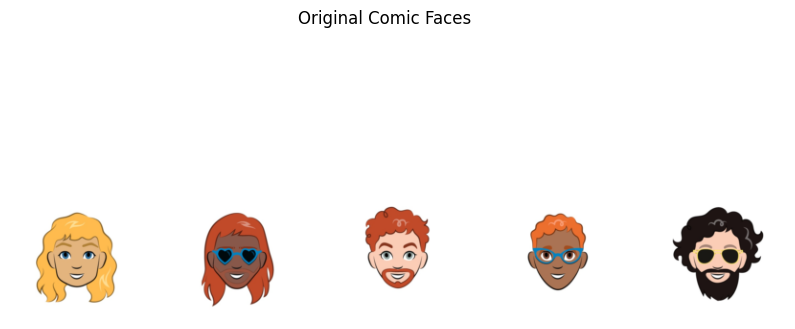

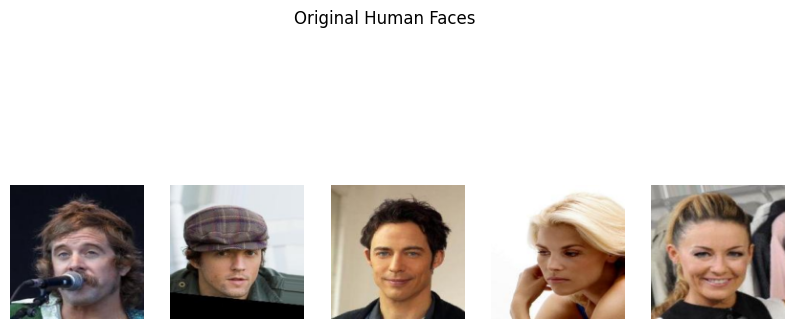

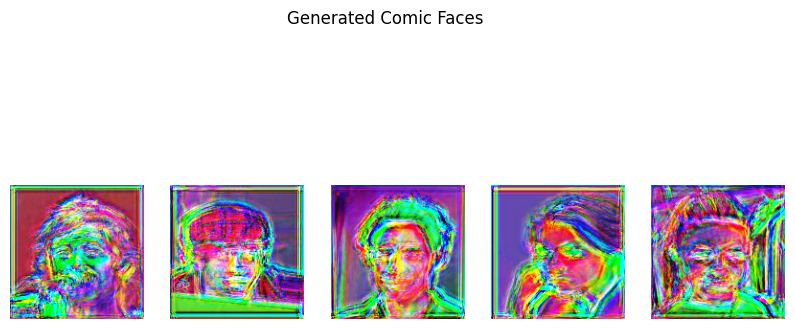

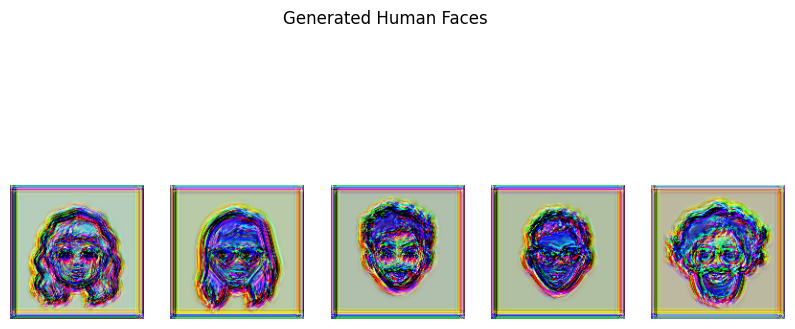

In [7]:
from utils import Generator, Discriminator, Joint_Model, train
import matplotlib.pyplot as plt

discriminator_a = Discriminator().cuda()
discriminator_b = Discriminator().cuda()

generator_a = Generator().cuda()
generator_b = Generator().cuda()

joint_model_b = Joint_Model(generator_b, generator_a, discriminator_b)
joint_model_a = Joint_Model(generator_a, generator_b, discriminator_a)

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image.cpu())
        axs[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 5
with torch.no_grad():
  generated_a = []
  generated_b = []
  image_a = []
  image_b = []
  for i in range(num_images):
    temp_image_a, temp_image_b = next(iter(dataloader))
    temp_image_a = temp_image_a.cuda()
    temp_image_b = temp_image_b.cuda()
    temp_generated_a = generator_a(temp_image_b)
    temp_generated_b = generator_b(temp_image_a)

    temp_image_a = ((temp_image_a + 1) * 127.5).int()
    temp_image_b = ((temp_image_b + 1) * 127.5).int()
    temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
    temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

    image_a.append(temp_image_a)
    image_b.append(temp_image_b)
    generated_a.append(temp_generated_a)
    generated_b.append(temp_generated_b)

  plot_images(image_a, "Original Comic Faces", num_images)
  plot_images(image_b, "Original Human Faces", num_images)
  plot_images(generated_a, "Generated Comic Faces", num_images)
  plot_images(generated_b, "Generated Human Faces", num_images)

As you can see, the initial results are horrible, so there is a lot of room for improvement. So, let's train the model!


In [ ]:
from utils import Generator, Discriminator, Joint_Model, train

discriminator_a = Discriminator()
discriminator_b = Discriminator()

# Load weights if possible
if os.path.exists('discriminator_a.pth'):
    discriminator_a.load_state_dict(torch.load('discriminator_a.pth'))

if os.path.exists('discriminator_b.pth'):
    discriminator_b.load_state_dict(torch.load('discriminator_b.pth'))

generator_a = Generator()
generator_b = Generator()

joint_model_b = Joint_Model(generator_b, generator_a, discriminator_b)
joint_model_a = Joint_Model(generator_a, generator_b, discriminator_a)

if os.path.exists('joint_model_a.pth'):
    joint_model_a.load_state_dict(torch.load('joint_model_a.pth'))

if os.path.exists('joint_model_b.pth'):
    joint_model_b.load_state_dict(torch.load('joint_model_b.pth'))

# Train the models
train(generator_a, generator_b, discriminator_a, discriminator_b, joint_model_a, joint_model_b, dataloader, batch_size, epochs=epochs)

Epoch 0, Batch 0, Descriminator A Loss: 1.414984941482544, Descriminator B Loss: 1.4032721519470215, Joint A Loss: 17.72726821899414, Joint B Loss: 15.537960052490234
Epoch 0, Batch 100, Descriminator A Loss: 0.1612972915172577, Descriminator B Loss: 1.332226276397705, Joint A Loss: 14.952766418457031, Joint B Loss: 8.860265731811523
Epoch 0, Batch 200, Descriminator A Loss: 0.341881662607193, Descriminator B Loss: 0.7710931897163391, Joint A Loss: 9.86292552947998, Joint B Loss: 6.266676425933838
Epoch 0, Batch 300, Descriminator A Loss: 0.04146462678909302, Descriminator B Loss: 0.7622483968734741, Joint A Loss: 13.065033912658691, Joint B Loss: 8.98293685913086
Epoch 0, Batch 400, Descriminator A Loss: 0.021439459174871445, Descriminator B Loss: 0.290594220161438, Joint A Loss: 14.675647735595703, Joint B Loss: 7.348793983459473
Epoch 0, Batch 500, Descriminator A Loss: 0.026719609275460243, Descriminator B Loss: 0.8169467449188232, Joint A Loss: 14.664810180664062, Joint B Loss: 9.

KeyboardInterrupt: 

I manually interrupted the training above to run a round of inference. Now, let's see what the outputs so far look like.

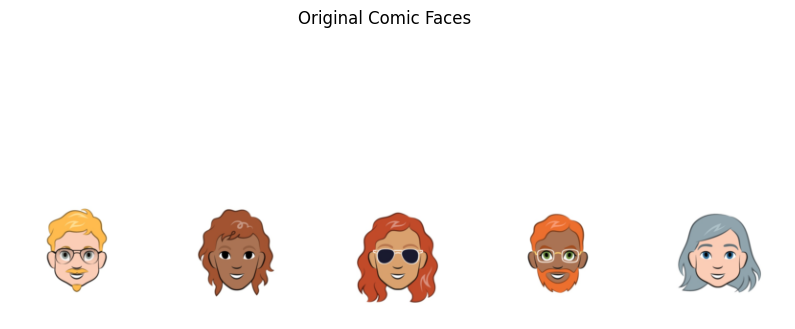

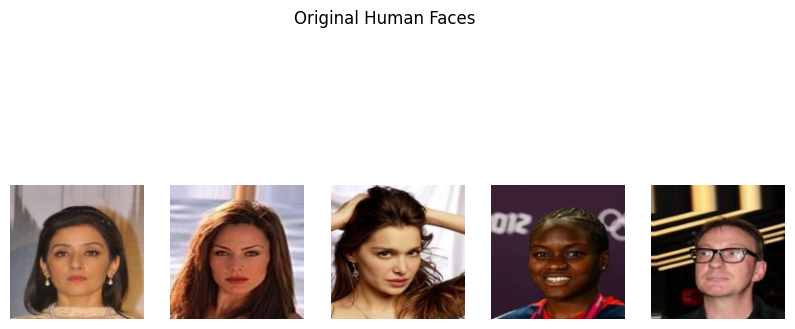

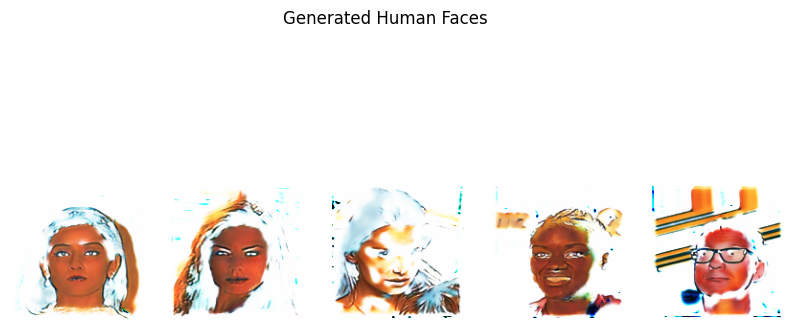

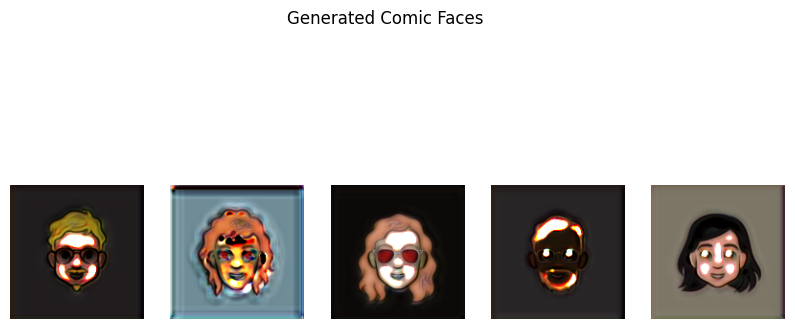

In [ ]:
# Inference
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image.cpu())
        axs[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 5
with torch.no_grad():
  generated_a = []
  generated_b = []
  image_a = []
  image_b = []
  for i in range(num_images):
    temp_image_a, temp_image_b = next(iter(dataloader))
    temp_image_a = temp_image_a.cuda()
    temp_image_b = temp_image_b.cuda()
    temp_generated_a = generator_a(temp_image_b)
    temp_generated_b = generator_b(temp_image_a)

    temp_image_a = ((temp_image_a + 1) * 127.5).int()
    temp_image_b = ((temp_image_b + 1) * 127.5).int()
    temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
    temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

    image_a.append(temp_image_a)
    image_b.append(temp_image_b)
    generated_a.append(temp_generated_a)
    generated_b.append(temp_generated_b)

  plot_images(image_a, "Original Comic Faces", num_images)
  plot_images(image_b, "Original Human Faces", num_images)
  plot_images(generated_a, "Generated Human Faces", num_images)
  plot_images(generated_b, "Generated Comic Faces", num_images)

 I just realized that the correct labels should have been "Generated Comic faces" for the first row and "Generated human faces" for the second row of results, but I won't re-run the code because as of the time of this writing, the model's weights have been
 updated

As we can see from the images above, our results are starting to look reasonable, but can benefit from additional training.

In [ ]:
# Train the models
train(generator_a, generator_b, discriminator_a, discriminator_b, joint_model_a, joint_model_b, dataloader, batch_size, epochs=epochs)

Epoch 0, Batch 0, Descriminator A Loss: 0.0018902617739513516, Descriminator B Loss: 6.740103708580136e-05, Joint A Loss: 11.81575870513916, Joint B Loss: 17.281269073486328
Epoch 0, Batch 100, Descriminator A Loss: 0.0006116411532275379, Descriminator B Loss: 0.00014932618068996817, Joint A Loss: 1.4484883546829224, Joint B Loss: 17.71982192993164
Epoch 0, Batch 200, Descriminator A Loss: 5.337806942407042e-05, Descriminator B Loss: 1.560056443850044e-05, Joint A Loss: 10.88876724243164, Joint B Loss: 12.338521003723145
Epoch 0, Batch 300, Descriminator A Loss: 0.0009864086750894785, Descriminator B Loss: 5.061196134192869e-05, Joint A Loss: 7.377049446105957, Joint B Loss: 14.843034744262695
Epoch 0, Batch 400, Descriminator A Loss: 7.025320883258246e-06, Descriminator B Loss: 2.0874493202427402e-05, Joint A Loss: 7.748371124267578, Joint B Loss: 16.672704696655273
Epoch 0, Batch 500, Descriminator A Loss: 0.028393447399139404, Descriminator B Loss: 0.0002358080237172544, Joint A Los

Now, let's test the model again

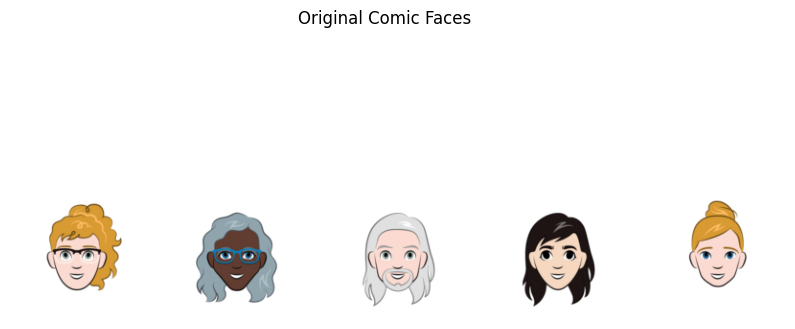

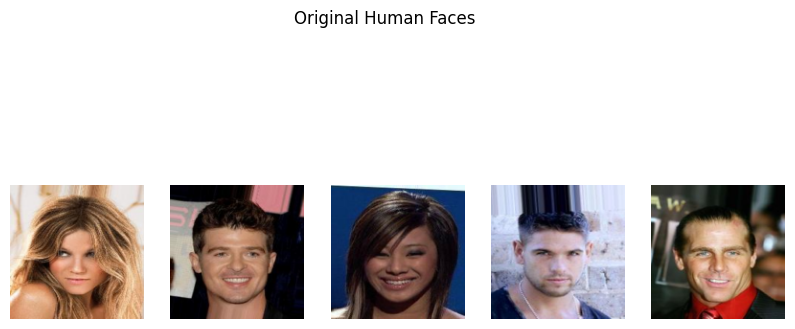

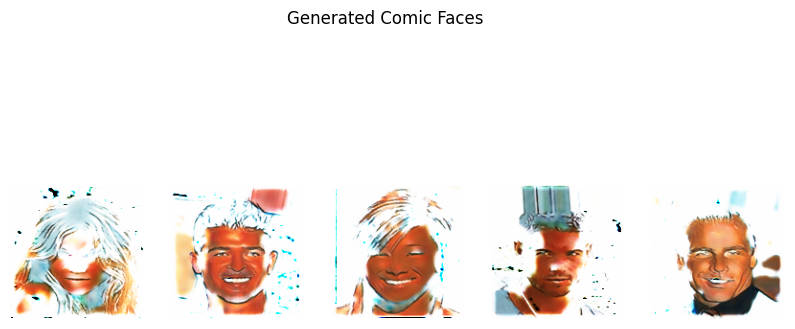

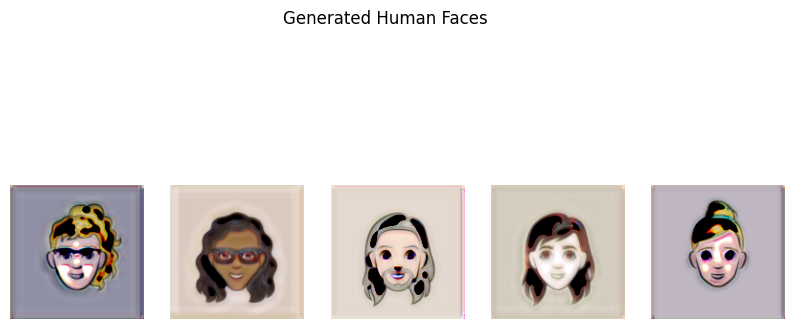

In [11]:
from utils import Generator, Discriminator, Joint_Model, train

discriminator_a = Discriminator()
discriminator_b = Discriminator()

# Load weights
discriminator_a.load_state_dict(torch.load('discriminator_a.pt'))
discriminator_a = discriminator_a.cuda()

discriminator_b.load_state_dict(torch.load('discriminator_b.pt'))
discriminator_b = discriminator_b.cuda()

generator_a = Generator()
generator_b = Generator()

joint_model_b = Joint_Model(generator_b, generator_a, discriminator_b)
joint_model_a = Joint_Model(generator_a, generator_b, discriminator_a)


joint_model_a.load_state_dict(torch.load('joint_a.pt'))
joint_model_a = joint_model_a.cuda()

joint_model_b.load_state_dict(torch.load('joint_b.pt'))
joint_model_b = joint_model_b.cuda()


# Inference
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image.cpu())
        axs[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 5
with torch.no_grad():
  generated_a = []
  generated_b = []
  image_a = []
  image_b = []
  for i in range(num_images):
    temp_image_a, temp_image_b = next(iter(dataloader))
    temp_image_a = temp_image_a.cuda()
    temp_image_b = temp_image_b.cuda()

    temp_generated_a= generator_a(temp_image_b)
    temp_generated_b = generator_b(temp_image_a)

    temp_image_a = ((temp_image_a + 1) * 127.5).int()
    temp_image_b = ((temp_image_b + 1) * 127.5).int()
    temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
    temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

    image_a.append(temp_image_a)
    image_b.append(temp_image_b)
    generated_a.append(temp_generated_a)
    generated_b.append(temp_generated_b)

  plot_images(image_a, "Original Comic Faces", num_images)
  plot_images(image_b, "Original Human Faces", num_images)
  plot_images(generated_a, "Generated Comic Faces", num_images)
  plot_images(generated_b, "Generated Human Faces", num_images)

As we can see, the results have gotten much better since our previous training run. However, there are still points of improvement, such as the black dots on the comic faces and the white spots on the human faces. I believe that these could be improved by using a larger model (more residual blocks on the generator), using a loss function that prioritizes the center of the image (where the face is located), and training for more epochs.

Now, let's generate a grid of 50 images with the original human faces and the generated cartoon faces

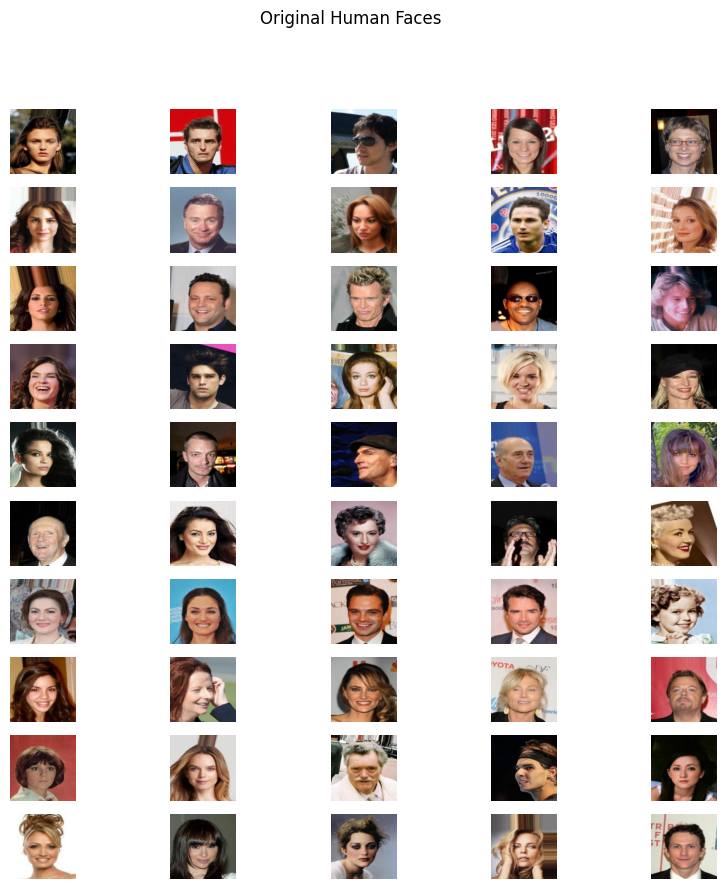

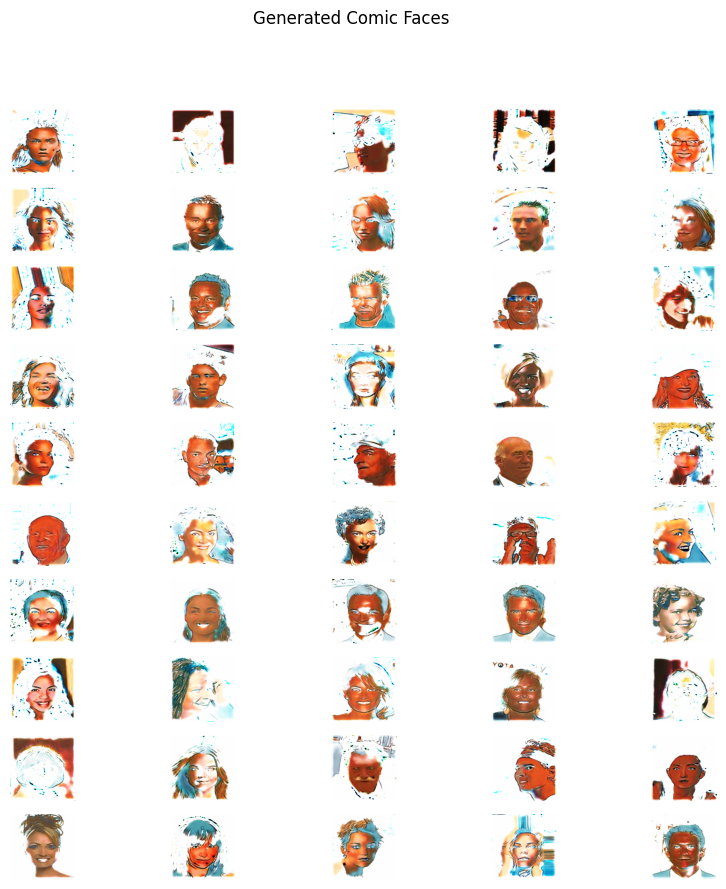

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(10, 10))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i // 5, i % 5].imshow(image.cpu())
        axs[i // 5, i % 5].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 50

with torch.no_grad():
    generated_a = []
    generated_b = []
    image_a = []
    image_b = []
    for i in range(num_images):
        temp_image_a, temp_image_b = next(iter(dataloader))
        temp_image_a = temp_image_a.cuda()
        temp_image_b = temp_image_b.cuda()
        temp_generated_a = generator_a(temp_image_b)
        temp_generated_b = generator_b(temp_image_a)

        temp_image_a = ((temp_image_a + 1) * 127.5).int()
        temp_image_b = ((temp_image_b + 1) * 127.5).int()
        temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
        temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

        image_a.append(temp_image_a)
        image_b.append(temp_image_b)
        generated_a.append(temp_generated_a)
        generated_b.append(temp_generated_b)

    plot_images(image_b, "Original Human Faces", num_images)
    plot_images(generated_a, "Generated Comic Faces", num_images)

Now, let's generate the same grid of 50 images, but with the original comic faces and the generated human faces

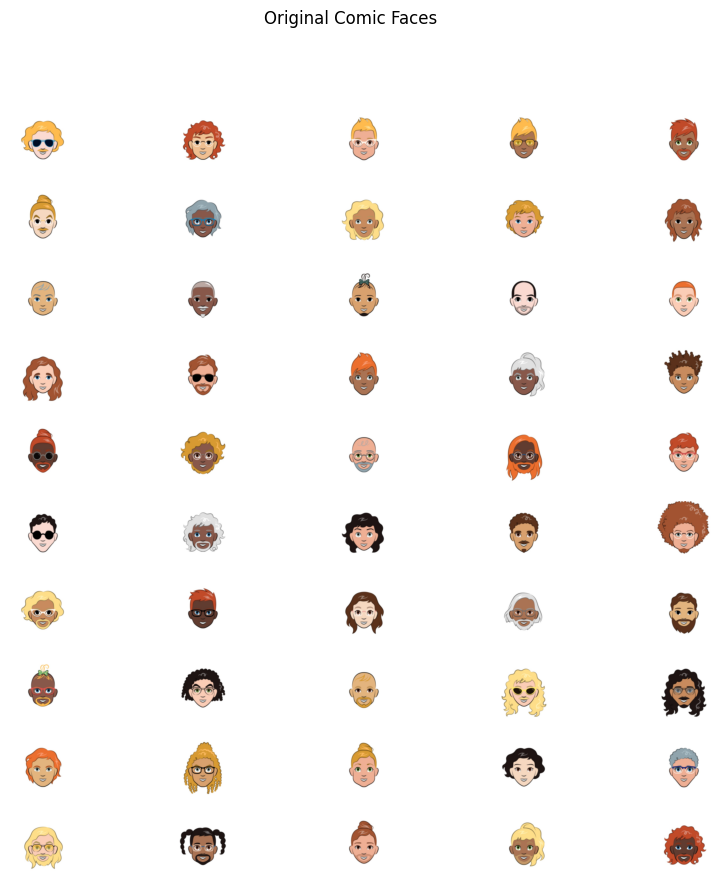

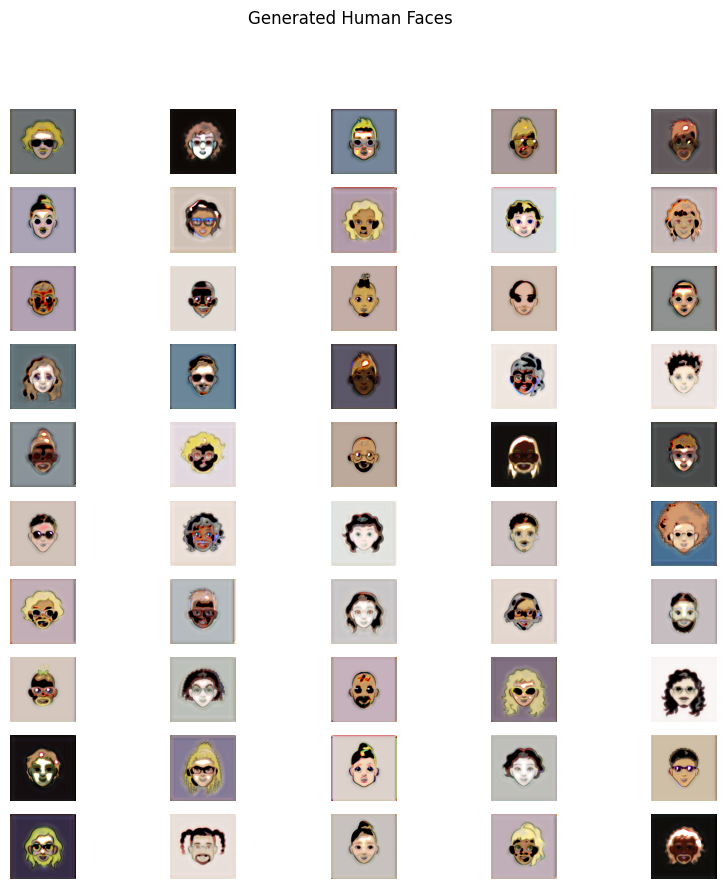

In [10]:
# Generate images
num_images = 50

with torch.no_grad():
    generated_a = []
    generated_b = []
    image_a = []
    image_b = []
    for i in range(num_images):
        temp_image_a, temp_image_b = next(iter(dataloader))
        temp_image_a = temp_image_a.cuda()
        temp_image_b = temp_image_b.cuda()
        temp_generated_a = generator_a(temp_image_b)
        temp_generated_b = generator_b(temp_image_a)

        temp_image_a = ((temp_image_a + 1) * 127.5).int()
        temp_image_b = ((temp_image_b + 1) * 127.5).int()
        temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
        temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

        image_a.append(temp_image_a)
        image_b.append(temp_image_b)
        generated_a.append(temp_generated_a)
        generated_b.append(temp_generated_b)

    plot_images(image_a, "Original Comic Faces", num_images)
    plot_images(generated_b, "Generated Human Faces", num_images)

Lastly, we should run two important sanity checks. The first check is that we get exactly the same image we inputted if we insert a human face
onto the generator used to create human faces and, similarly, if we insert a comic face into the generator used to create comic faces, we
should get the exact comic face input given by the comic face generator.
The code below is exactly equal to the first inference code, but with temp_image_a as input to generator_a and
temp_image_b as input to generator_b.

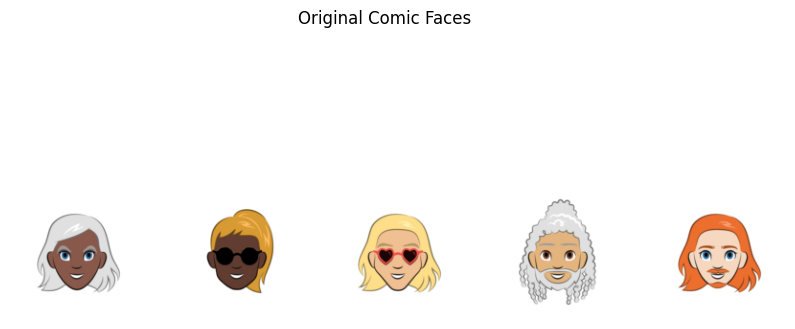

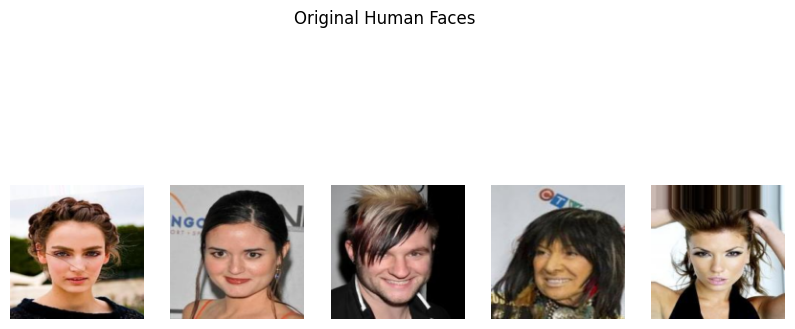

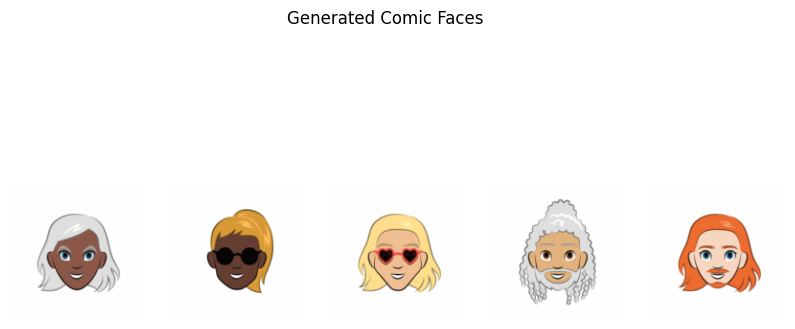

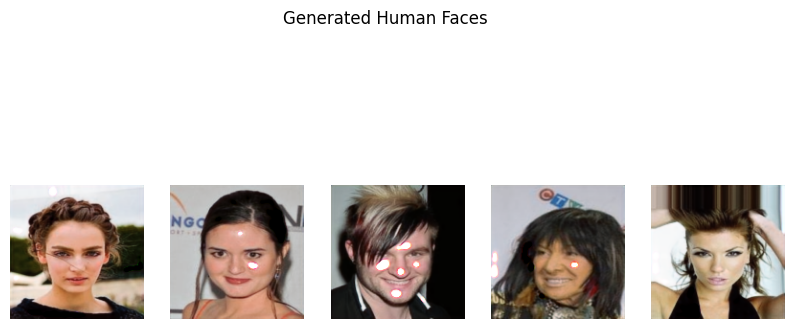

In [8]:
from utils import Generator, Discriminator, Joint_Model, train

discriminator_a = Discriminator()
discriminator_b = Discriminator()

# Load weights
discriminator_a.load_state_dict(torch.load('discriminator_a.pt'))
discriminator_a = discriminator_a.cuda()

discriminator_b.load_state_dict(torch.load('discriminator_b.pt'))
discriminator_b = discriminator_b.cuda()

generator_a = Generator()
generator_b = Generator()

joint_model_b = Joint_Model(generator_b, generator_a, discriminator_b)
joint_model_a = Joint_Model(generator_a, generator_b, discriminator_a)


joint_model_a.load_state_dict(torch.load('joint_a.pt'))
joint_model_a = joint_model_a.cuda()

joint_model_b.load_state_dict(torch.load('joint_b.pt'))
joint_model_b = joint_model_b.cuda()


# Inference
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image.cpu())
        axs[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 5
with torch.no_grad():
  generated_a = []
  generated_b = []
  image_a = []
  image_b = []
  for i in range(num_images):
    temp_image_a, temp_image_b = next(iter(dataloader))
    temp_image_a = temp_image_a.cuda()
    temp_image_b = temp_image_b.cuda()

    temp_generated_a= generator_a(temp_image_a)
    temp_generated_b = generator_b(temp_image_b)

    temp_image_a = ((temp_image_a + 1) * 127.5).int()
    temp_image_b = ((temp_image_b + 1) * 127.5).int()
    temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
    temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

    image_a.append(temp_image_a)
    image_b.append(temp_image_b)
    generated_a.append(temp_generated_a)
    generated_b.append(temp_generated_b)

  plot_images(image_a, "Original Comic Faces", num_images)
  plot_images(image_b, "Original Human Faces", num_images)
  plot_images(generated_a, "Generated Comic Faces", num_images)
  plot_images(generated_b, "Generated Human Faces", num_images)


As we can see, our results are as expected, with the exception of a few white spots on the image.

Now, our last sanity check is to determine the following:

- If we insert a human image into the comic faces generator and then use the generated comic image in the human faces generator, will our final output look like the original human face? This will be used to assess cycle consistency.

The same process applies to inserting a comic face. Luckily, this is already coded as the third output provided by the forward pass of our joint model class.



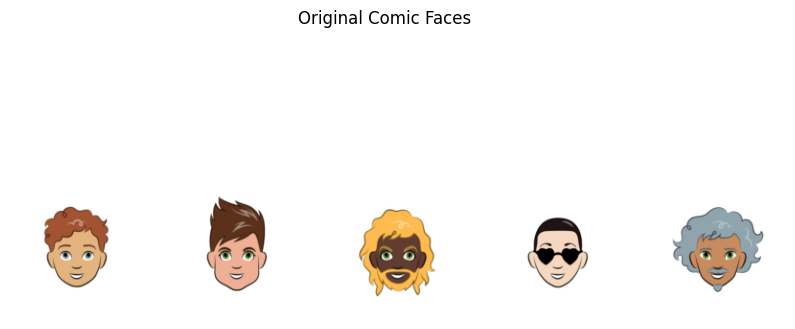

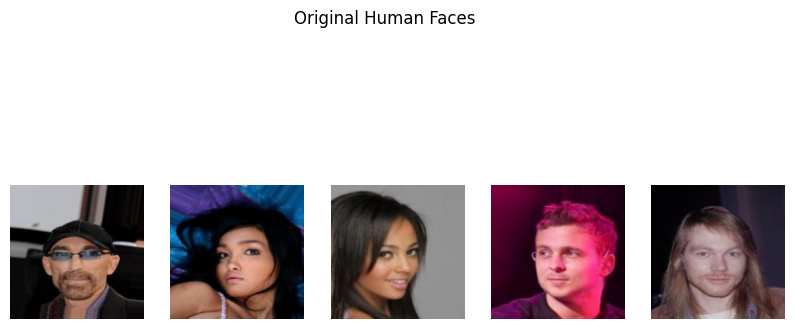

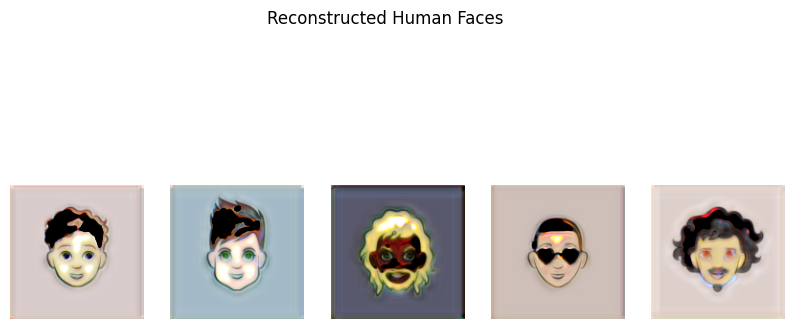

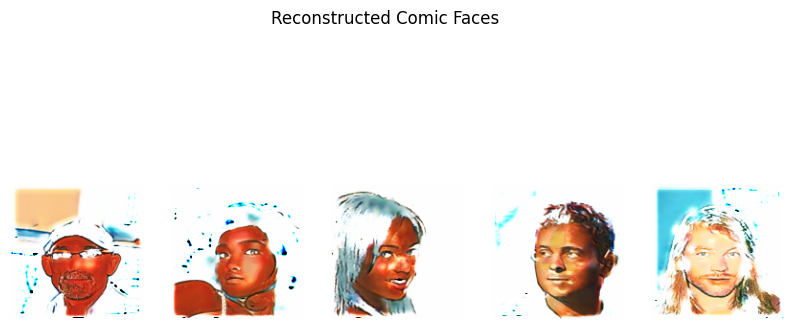

In [14]:
from utils import Generator, Discriminator, Joint_Model, train

discriminator_a = Discriminator()
discriminator_b = Discriminator()

# Load weights
discriminator_a.load_state_dict(torch.load('discriminator_a.pt'))
discriminator_a = discriminator_a.cuda()

discriminator_b.load_state_dict(torch.load('discriminator_b.pt'))
discriminator_b = discriminator_b.cuda()

generator_a = Generator()
generator_b = Generator()

joint_model_b = Joint_Model(generator_b, generator_a, discriminator_b)
joint_model_a = Joint_Model(generator_a, generator_b, discriminator_a)


joint_model_a.load_state_dict(torch.load('joint_a.pt'))
joint_model_a = joint_model_a.cuda()

joint_model_b.load_state_dict(torch.load('joint_b.pt'))
joint_model_b = joint_model_b.cuda()


# Inference
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, num_images=5):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 5))

    for i in range(num_images):
        image = images[i][0]
        image = image.permute(1, 2, 0)
        axs[i].imshow(image.cpu())
        axs[i].axis('off')

    fig.suptitle(title)
    plt.show()

# Generate images
num_images = 5
with torch.no_grad():
  generated_a = []
  generated_b = []
  image_a = []
  image_b = []
  for i in range(num_images):
    temp_image_a, temp_image_b = next(iter(dataloader))
    temp_image_a = temp_image_a.cuda()
    temp_image_b = temp_image_b.cuda()

    _, _, temp_generated_a, _ = joint_model_a(temp_image_a, temp_image_b)
    _, _, temp_generated_b, _ = joint_model_b(temp_image_b, temp_image_a)

    temp_image_a = ((temp_image_a + 1) * 127.5).int()
    temp_image_b = ((temp_image_b + 1) * 127.5).int()
    temp_generated_a = ((temp_generated_a + 1) * 127.5).int()
    temp_generated_b = ((temp_generated_b + 1) * 127.5).int()

    image_a.append(temp_image_a)
    image_b.append(temp_image_b)
    generated_a.append(temp_generated_a)
    generated_b.append(temp_generated_b)

  plot_images(image_a, "Original Comic Faces", num_images)
  plot_images(image_b, "Original Human Faces", num_images)
  plot_images(generated_a, "Reconstructed Human Faces", num_images)
  plot_images(generated_b, "Reconstructed Comic Faces", num_images)


Although there are obvious differences between the reconstructed images and the original ones, the reconstructed versions are more similar to the original (especially in terms of background details and granularity of facial features) than the images generated by running a forward pass on either generator A or B. This shows that, although the quality of its outputs are far from perfect, this CycleGAN model passes the two sanity checks above (identity images and cycle consistency). Furthermore, the difficulty in reconstructing images is likely due to the fact that the human to comic face generator sets the majority of the background as white, making it difficult for the comic to human generator to determine the original color of the background and features further from the face (such as hair and hats). 